In [1]:
# to load csv file into dataframe using pandas
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import numpy as np

# imports related to neural network modules in pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as dataUtils

# imports for preprocessing of data using sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [2]:
# Read data from csv file dataset.csv using pandas read_csv
dataframe = pd.read_csv('./dataset.csv')
dataframe

,f1,f2,f3,f4,f5,f6,f7,target
0,6,148,72,35,0,33.6,0.627,1
1,1,85,66,29,0,26.6,0.351,0
2,8,183,64,0,0,23.3,0.672,1
3,1,89,66,23,94,28.1,0.167,0
4,0,137,40,35,168,43.1,2.288,1
...,...,...,...,...,...,...,...,...
761,9,89,62,0,0,22.5,e,0
762,10,101,76,48,180,d,0.171,0
763,2,122,70,27,b,36.8,0.34,0
764,c,121,72,23,112,26.2,0.245,0


In [3]:
# preprocess data by removing rows with wrong datatype
dataframe = dataframe.replace(regex={'[a-zA-Z]+':None})
dataframe = dataframe.dropna()
dataframe = dataframe.astype(float)
dataframe

,f1,f2,f3,f4,f5,f6,f7,target
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,1.0
1,1.0,85.0,66.0,29.0,0.0,26.6,0.351,0.0
2,8.0,183.0,64.0,0.0,0.0,23.3,0.672,1.0
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,0.0
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,1.0
...,...,...,...,...,...,...,...,...
755,1.0,128.0,88.0,39.0,110.0,36.5,1.057,1.0
756,7.0,137.0,90.0,41.0,0.0,32.0,0.391,0.0
757,0.0,123.0,72.0,0.0,0.0,36.3,0.258,1.0
758,1.0,106.0,76.0,0.0,0.0,37.5,0.197,0.0


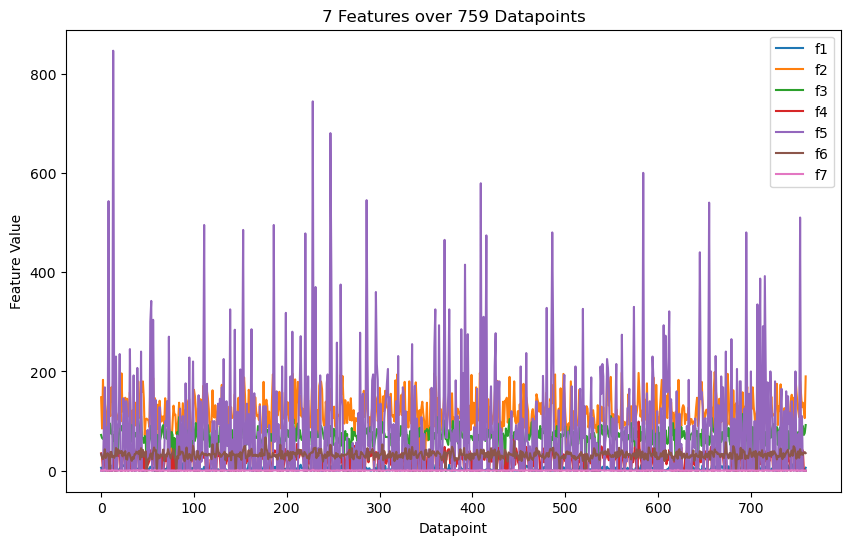

In [4]:

y_map = {}
features = [col for col in dataframe.columns if col != 'target']

for feature in features:
    y_map[feature] = dataframe[feature].values
    
x = dataframe.index.values

fig, ax = plt.subplots(figsize=(10, 6))

for feature in features:
    ax.plot(x,y_map[feature], label=feature)

ax.set_title('7 Features over 759 Datapoints')
ax.set_xlabel('Datapoint')
ax.set_ylabel('Feature Value')

ax.legend()

plt.show()

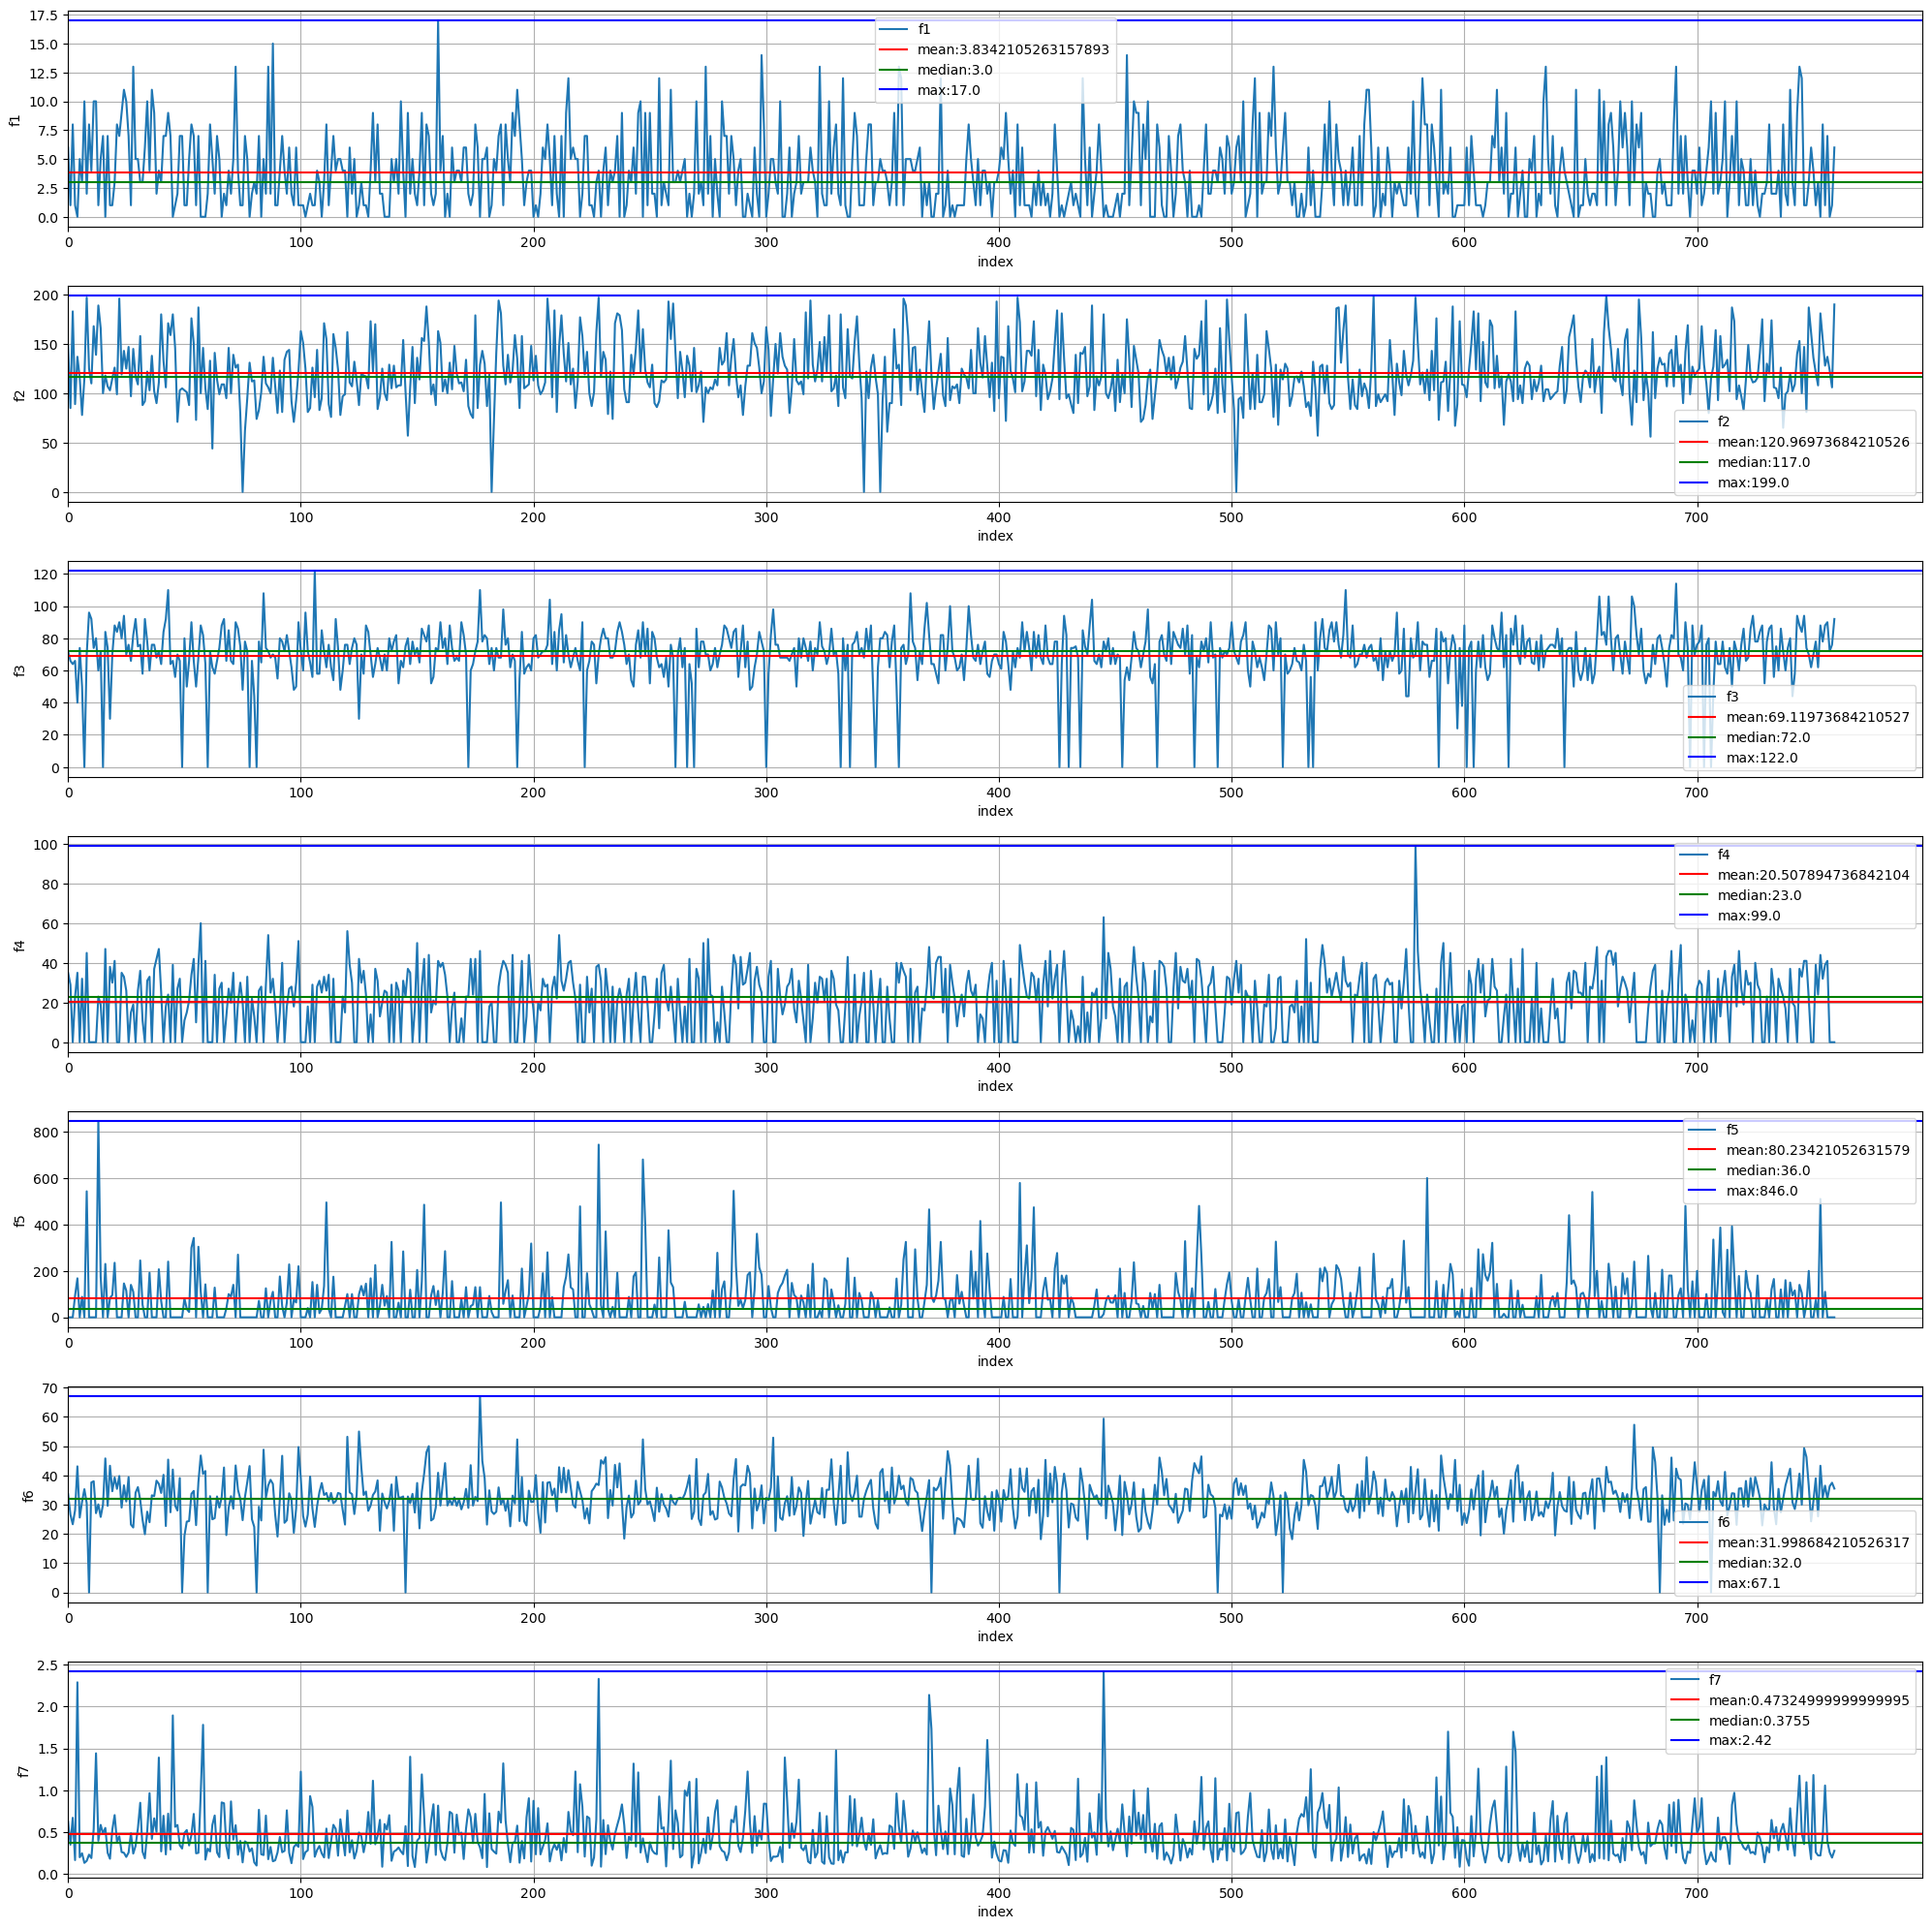

In [5]:
fig, axs = plt.subplots(len(features),1, figsize=(20, 20))
x = dataframe.index.values
for i, feature in enumerate(features):
    ax = axs[i]
    ax.plot(dataframe[feature], label=feature)
    ax.set_ylabel(feature)
    ax.set_xlabel('index')

    mean = np.mean(dataframe[feature])
    median = np.median(dataframe[feature])
    y_max = np.max(dataframe[feature])

    ax.axhline(mean, color='r', label='mean:'+str(mean))
    ax.axhline(median, color='g', label='median:'+str(median))
    ax.axhline(y_max, color='b', label='max:' + str(y_max))
    ax.set_xbound(0)
    ax.legend()

    ax.grid(True)

plt.tight_layout()

plt.show()

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [7]:
class NeuralNetwork(nn.Module):
    def addLayer(self,layers,config):
        if config['type'] == "Linear":
            linear = nn.Linear(config['input_size'], config['output_size'])
            nn.init.xavier_uniform_(linear.weight)
            nn.init.zeros_(linear.bias)
            layers.append(linear)
            
        elif config['type'] == "ReLU":
            layers.append(nn.ReLU())
        elif config['type'] == "tanh":
            layers.append(nn.Tanh())
            
        elif config['type'] == "LReLU":
            layers.append(nn.LeakyReLU())
        elif config['type'] == "Dropout":
            layers.append(nn.Dropout(config['p']))
        elif config['type'] == "Norm":
            layers.append(nn.BatchNorm1d(config['size']))
        elif config['type'] == "sigmoid":
            layers.append(nn.Sigmoid())
        
    def __init__(self, model_config):
        super(NeuralNetwork, self).__init__()

        layers = []
        for layerConfig in model_config['layers']:
            self.addLayer(layers, layerConfig)
         
        self.layers = nn.Sequential(*layers)
    
    def forward(self,x):
        x = self.layers(x)
        x = torch.sigmoid(x)

        return x


In [8]:
model_config = {}
model_config['input_size'] = 7
model_config['layers'] = []

In [9]:

def createModelConfigWithReLu(model_config, dropout = 0.0):
    model_config['layers'].extend([
            {
                "type" : "Linear",
                "input_size" : 7,
                "output_size" : 64
            },
            {
                "type" : "LReLU"
            },
            {
                "type": "Dropout",
                "p" : dropout 
            },
            {
                "type" : "Linear",
                "input_size" : 64,
                "output_size" : 64
            },
            {
                "type" : "Norm",
                "size" : 64
            },
            {
                "type": "Dropout",
                "p" : dropout 
            },
            {
                "type" : "Linear",
                "input_size" : 64,
                "output_size" : 64
            },
            {
                "type" : "LReLU"
            },
            {
                "type": "Dropout",
                "p" : dropout
            },
            {
                "type" : "Linear",
                "input_size" : 64,
                "output_size" : 1
            }
        ])

In [10]:
createModelConfigWithReLu(model_config)
model = NeuralNetwork(model_config)
model = model.to(device)
model

NeuralNetwork(
  (layers): Sequential(
    (0): Linear(in_features=7, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Dropout(p=0.0, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [11]:
# tools for preprocessing the above dataset -> creating instance of the tools
encoder = OneHotEncoder(handle_unknown='ignore')
scaler = StandardScaler()

In [12]:
# splitting target from dataset to normalize the data
target = dataframe['target']
input_data = dataframe.drop(['target'],axis=1)

In [13]:
input_data

,f1,f2,f3,f4,f5,f6,f7
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627
1,1.0,85.0,66.0,29.0,0.0,26.6,0.351
2,8.0,183.0,64.0,0.0,0.0,23.3,0.672
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288
...,...,...,...,...,...,...,...
755,1.0,128.0,88.0,39.0,110.0,36.5,1.057
756,7.0,137.0,90.0,41.0,0.0,32.0,0.391
757,0.0,123.0,72.0,0.0,0.0,36.3,0.258
758,1.0,106.0,76.0,0.0,0.0,37.5,0.197


In [14]:
target

0      1.0
1      0.0
2      1.0
3      0.0
4      1.0
      ... 
755    1.0
756    0.0
757    1.0
758    0.0
759    1.0
Name: target, Length: 760, dtype: float64

In [15]:
encoder.fit(input_data)
input_data = pd.DataFrame(scaler.fit_transform(input_data),columns=input_data.columns)

In [16]:
# input data after preprocessing
input_data

,f1,f2,f3,f4,f5,f6,f7
0,0.644092,0.844637,0.148213,0.908737,-0.694636,0.202839,0.463021
1,-0.842876,-1.123976,-0.160536,0.532503,-0.694636,-0.683852,-0.368158
2,1.238879,1.938311,-0.263452,-1.285961,-0.694636,-1.101863,0.598540
3,-0.842876,-0.998985,-0.160536,0.156269,0.119179,-0.493847,-0.922278
4,-1.140270,0.500911,-1.498446,0.908737,0.759842,1.406204,5.465156
...,...,...,...,...,...,...,...
755,-0.842876,0.219680,0.971542,1.159559,0.257700,0.570182,1.757975
756,0.941485,0.500911,1.074458,1.284971,-0.694636,0.000167,-0.247698
757,-1.140270,0.063441,0.148213,-1.285961,-0.694636,0.544848,-0.648230
758,-0.842876,-0.467772,0.354045,-1.285961,-0.694636,0.696852,-0.831932


In [17]:
input_data.describe()

,f1,f2,f3,f4,f5,f6,f7
count,7.600000e+02,7.600000e+02,7.600000e+02,7.600000e+02,7.600000e+02,7.600000e+02,7.600000e+02
mean,3.739699e-17,9.349247e-18,-2.898266e-16,9.582978e-17,2.337312e-18,-1.986715e-16,1.519253e-16
std,1.000659e+00,1.000659e+00,1.000659e+00,1.000659e+00,1.000659e+00,1.000659e+00,1.000659e+00
min,-1.140270e+00,-3.780041e+00,-3.556770e+00,-1.285961e+00,-6.946361e-01,-4.053275e+00,-1.190303e+00
25%,-8.428760e-01,-6.865065e-01,-2.891809e-01,-1.285961e+00,-6.946361e-01,-5.951826e-01,-6.911439e-01
50%,-2.480889e-01,-1.240456e-01,1.482128e-01,1.562691e-01,-3.829623e-01,1.666711e-04,-2.943761e-01
75%,6.440919e-01,6.259022e-01,5.598776e-01,7.206199e-01,4.157018e-01,5.828490e-01,4.645270e-01
max,3.915421e+00,2.438276e+00,2.721117e+00,4.921898e+00,6.629698e+00,4.446286e+00,5.862677e+00


In [18]:
#train test split
def train_test_split(input, target ,percent):
    size = len(target)
    train_size = int((1.0 - percent) * size)

    return input[: train_size], target[: train_size], input[train_size:], target[train_size:]

In [19]:
train_data, train_target, test_data, test_target = train_test_split(input_data, target, 0.2)

In [20]:
print(len(train_target))
print(len(test_target))

608
152


In [21]:
train_data, train_target, val_data, val_target = train_test_split(train_data, train_target, 0.2)

In [22]:
print(len(train_data))
print(len(val_data))

486
122


In [23]:
batch_size = 20
learning_rate = 0.0001

In [24]:
# creating training data and making them into batches used for SGD process
trainingData = dataUtils.TensorDataset(torch.Tensor(train_data.values), torch.Tensor(train_target.values))
train_dataBatches = dataUtils.DataLoader(trainingData, batch_size=batch_size, shuffle=True)

In [25]:
testData = dataUtils.TensorDataset(torch.Tensor(test_data.values), torch.Tensor(test_target.values).type(torch.LongTensor))
test_dataBatches = dataUtils.DataLoader(testData, batch_size=batch_size, shuffle=False)

In [26]:
valData = dataUtils.TensorDataset(torch.Tensor(val_data.values), torch.Tensor(val_target.values).type(torch.LongTensor))
val_dataBatches = dataUtils.DataLoader(testData, batch_size=batch_size, shuffle=False)

In [27]:

loss_function = nn.BCELoss()
opimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [28]:
class ModelRunner:
    device = 'cpu'
    train_loss = 0.0
    eval_loss = 0.0
    eval_accur = 0.0
    loss_fn = nn.BCELoss()
    batch_size = 30
    test_predicted = []
    test_target = []
    model = None
    weights = torch.tensor(0)
    min_loss = 1.0
    max_accuracy = 0.0

    def init(self):
        self.train_loss = 0.0
        self.eval_loss = 0.0
        self.eval_accur = 0.0
        self.loss_fn = nn.BCELoss()
        self.batch_size = 30
        self.test_predicted = []
        self.test_target = []
        

    def __init__(self,model, device, loss_fn=nn.BCELoss(), batch_size=batch_size):
        self.device = device
        self.train_loss = 0.0
        self.eval_loss = 0.0
        self.eval_accur = 0.0
        self.loss_function = loss_fn
        self.batch_size = batch_size
        self.model = model
        self.weights = torch.tensor(0)
        self.min_loss = 1.0
        self.max_accuracy = 0.0

    def get_train_loss(self):
        return self.train_loss

    def train(self, data_loader, optim):
        total_loss = 0.0
        for datai in data_loader:
            inputs, labels = self.toDevice(datai)
            labels = labels.float()
            
            optim.zero_grad()

            outputs = self.model(inputs)
            loss = self.__calculate_loss(outputs, labels)
            loss.backward()

            optim.step()
            total_loss += loss.item() * self.batch_size
        
        self.train_loss = total_loss / (len(data_loader) * self.batch_size)
        return self

    def toDevice(self,input_target):
        input,target = input_target
        return input.to(self.device), target.to(self.device)

    def __calculate_loss(self, output_list, target_list):
        return self.loss_fn(output_list, target_list.reshape(-1,1))

    def __get_predicted(self, output):
        return torch.tensor([1.0 if val >= 0.5 else 0.0 for val in output])
    
    def __get_correct_predictions(self, output, target):
        return (output == target).sum().item()

    def eval(self, data_loader):
        self.test_target = []
        self.test_predicted = []
        
        total_loss = 0.0
        correct = 0
        with torch.no_grad():
            for datai in data_loader:
                inputs, labels = self.toDevice(datai)
                
                labels = labels.float()
                self.test_target.extend([val.item() for val in labels.reshape(-1,1)])

                outputs = self.model(inputs)
                self.test_predicted.extend([val.item() for val in outputs.reshape(-1,1)])

                loss = self.__calculate_loss(outputs, labels)

                total_loss += loss.item() * batch_size
                predicted = self.__get_predicted(outputs)
                correct += self.__get_correct_predictions(predicted, labels)

        loss = total_loss / (len(data_loader) * self.batch_size)
        acc = accuracy_score(self.__get_predicted(self.test_predicted), self.test_target)
        self.eval_loss = loss
        self.eval_accur = acc
        return self
        
    def get_eval_stats(self):
        return self.eval_loss, self.eval_accur, self.__get_predicted(self.test_predicted), self.test_target
        

In [29]:
class StoreStats:
    loss = []
    accuracy = []
    
    def __init__(self):
        self.loss = []
        self.accuracy = []
    def add_loss(self, loss):
        self.loss.append(loss)
    def add_accuracy(self, accuracy):
        self.accuracy.append(accuracy)

def run(model, opimizer, epochs, train_dataBatches, val_dataBatches, scheduler = None):
    max_epoch = 0
    accuracy = 0.0
    loss = 0.0

    train_stats_obj = StoreStats()
    test_stats_obj = StoreStats()
    runner = ModelRunner(model, device,loss_fn=loss_function, batch_size=batch_size)

    
    for epoch in range(epochs):
        runner = runner.train(train_dataBatches, opimizer)
        train_loss = runner.get_train_loss()
        

        runner = runner.eval(train_dataBatches)
        train_loss, train_acc,_,_ = runner.get_eval_stats()

        train_stats_obj.add_loss(train_loss)
        train_stats_obj.add_accuracy(train_acc)

        runner = runner.eval(val_dataBatches)
        val_loss, val_acc,_,_ = runner.get_eval_stats()
        
        if scheduler is not None:
            scheduler.step(val_loss)
        
        test_stats_obj.add_loss(val_loss)
        test_stats_obj.add_accuracy(val_acc)
        
        # print(f'epoch : {epoch} loss : {val_loss:.4f} and  accuracy : {val_acc:.4f}')

        if val_acc > accuracy:
            max_epoch = epoch
            accuracy = val_acc
            loss = val_loss
            runner.weights = model.state_dict()
            runner.min_loss = min(runner.min_loss, loss)
            runner.max_accuracy = max(runner.max_accuracy, accuracy)
        
    return runner, train_stats_obj, test_stats_obj


In [30]:
epochs = 500
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
runner, train_stats_obj, test_stats_obj = run(model, optimizer ,epochs,train_dataBatches,val_dataBatches)
runner = runner.eval(test_dataBatches)

In [31]:

test_loss, test_accuracy,test_predicted,test_target = runner.get_eval_stats()
print(f'loss : {test_loss:.4f} and  accuracy : {test_accuracy:.4f}')
print(f'loss : {runner.min_loss:.4f} and  accuracy : {runner.max_accuracy:.4f}')

loss : 0.5142 and  accuracy : 0.7500
loss : 0.5860 and  accuracy : 0.7566


In [32]:
torch.save(runner.weights, 'hpoola_assignment2_checkpoint_1' + str((test_accuracy*100))+ '.pth')

In [33]:
def plot_train_test(epochs, train_data, test_data, type):
    x_data = np.arange(0,epochs,1)

    plt.plot(x_data, train_data,label='train ' + type)
    plt.plot(x_data, test_data, label='test ' + type)
    plt.legend()
    plt.show()


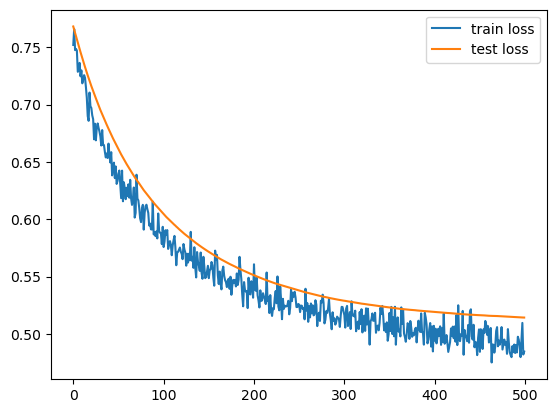

In [34]:
plot_train_test(epochs, train_stats_obj.loss, test_stats_obj.loss, 'loss')

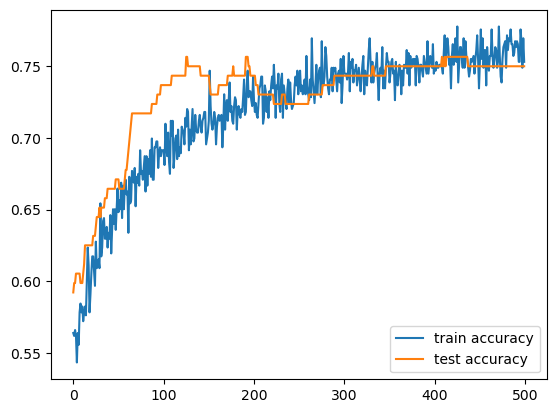

In [35]:
plot_train_test(epochs, train_stats_obj.accuracy, test_stats_obj.accuracy, 'accuracy')

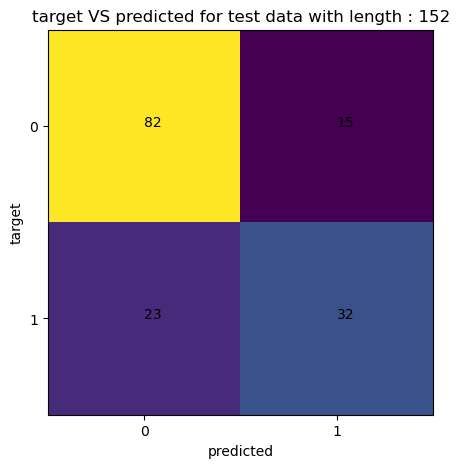

In [36]:
classes = [0,1]
conf_matrix = confusion_matrix(np.array(test_target), np.array(test_predicted))
_, axes = plt.subplots(figsize=(5, 5))

axes.set(xticks=classes,yticks=classes,xticklabels=classes, yticklabels=classes,
       title='target VS predicted for test data with length : ' + str(len(testData)),ylabel='target',xlabel='predicted')

axes.text(0, 0, format(conf_matrix[0, 0]))
axes.text(0, 1, format(conf_matrix[1, 0]))
axes.text(1, 0, format(conf_matrix[0, 1]))
axes.text(1, 1, format(conf_matrix[1, 1]))


axes.imshow(conf_matrix)


Part - 2

In [37]:
# considering the base model from part-1 as the model with highest accuracy
max_acc_model = model
max_accuracy = test_accuracy
max_model_config = model_config

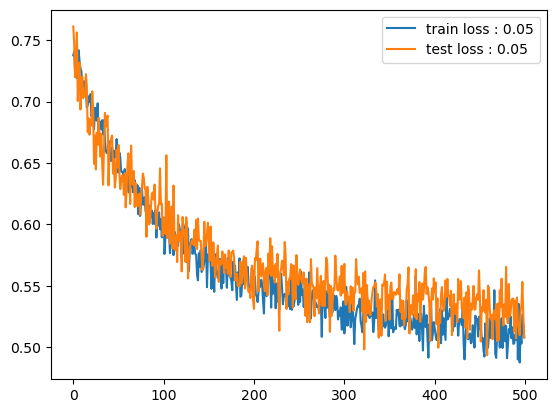

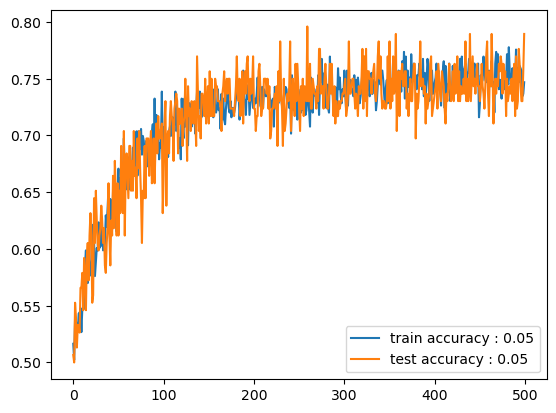

loss : 0.5382 and  accuracy : 0.7434


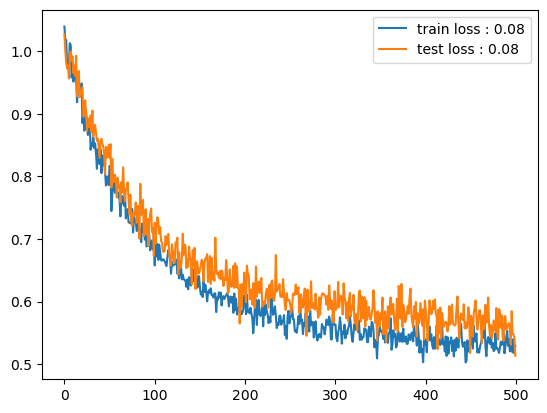

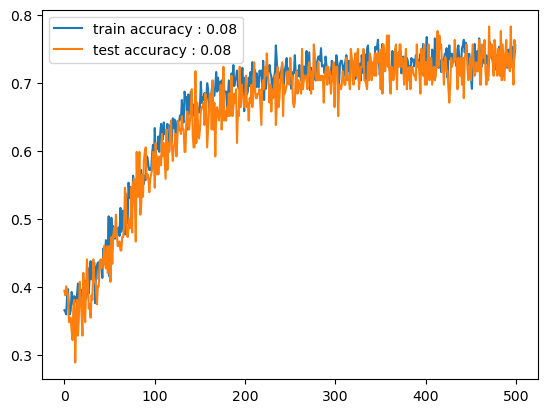

loss : 0.5181 and  accuracy : 0.7434


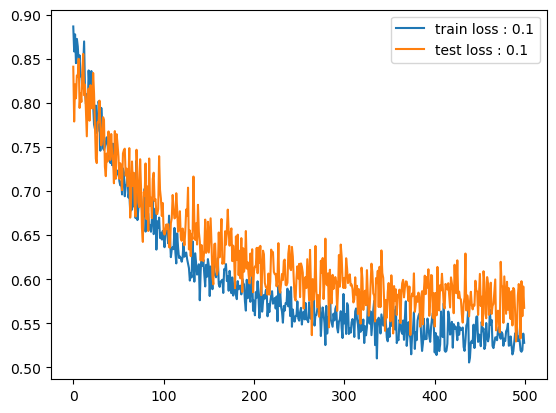

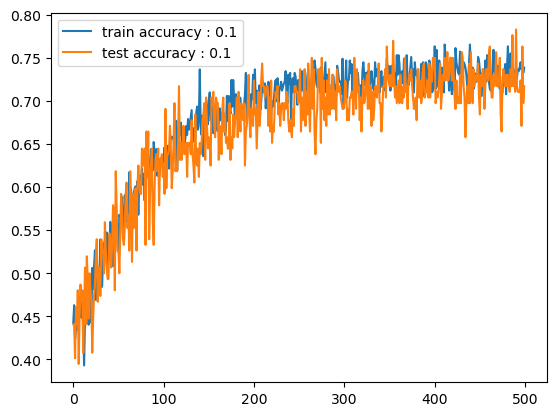

loss : 0.5790 and  accuracy : 0.7105


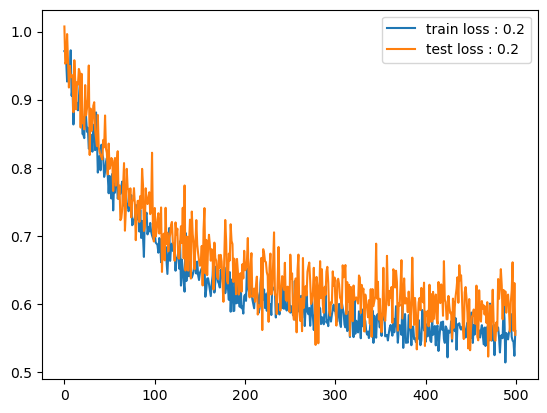

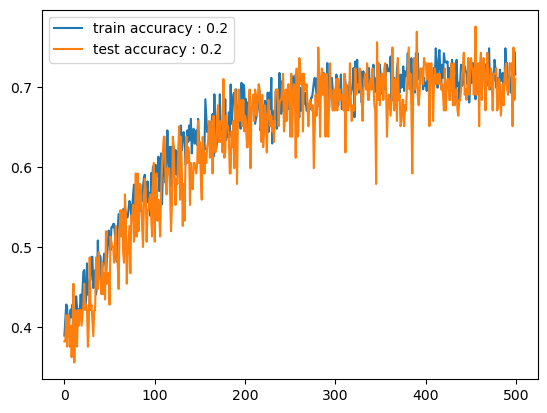

loss : 0.6270 and  accuracy : 0.6842


,dropout,loss,accuracy
0,0.05,0.538207,0.743421
1,0.08,0.518068,0.743421
2,0.10,0.579011,0.710526
3,0.20,0.626975,0.684211


In [38]:
# with different dropout values
epochs = 500
model_config = {}
model_config['input_size'] = 7
model_config['layers'] = []

dropout_vals = [0.05, 0.08, 0.1, 0.2]
df_dropout = []
models_with_dropout = []
for dropout in dropout_vals:
    model_config['layers'] = []
    createModelConfigWithReLu(model_config, dropout)
    model = NeuralNetwork(model_config)
    model = model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
    runner, train_stats, test_stats = run(model, optimizer ,epochs,train_dataBatches,val_dataBatches)
    
    plot_train_test(epochs, train_stats.loss, test_stats.loss, 'loss : ' + str(dropout))
    plot_train_test(epochs, train_stats.accuracy, test_stats.accuracy, 'accuracy : ' + str(dropout))
    
    runner = runner.eval(test_dataBatches)
    loss, accuracy,_,_ = runner.get_eval_stats()
    df_dropout.append({
        "dropout" : dropout,
        "loss" : loss,
        "accuracy" : accuracy
    })
    
    if max_accuracy < accuracy:
        max_accuracy = accuracy
        max_acc_model = model
        max_model_config = model_config
    
    print(f'loss : {loss:.4f} and  accuracy : {accuracy:.4f}')


df_dropout = pd.DataFrame.from_records(df_dropout)
df_dropout


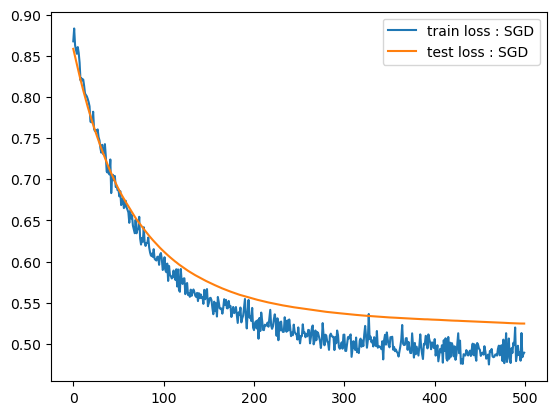

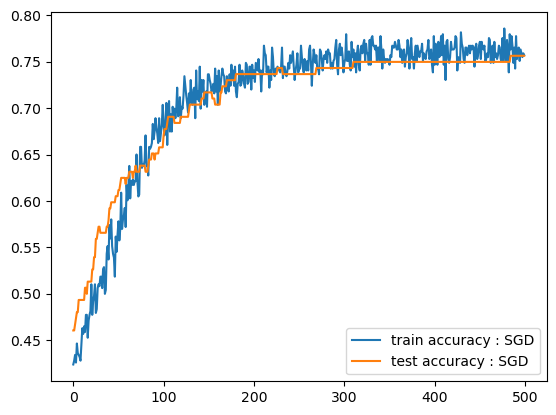

loss : 0.5246 and  accuracy : 0.7566


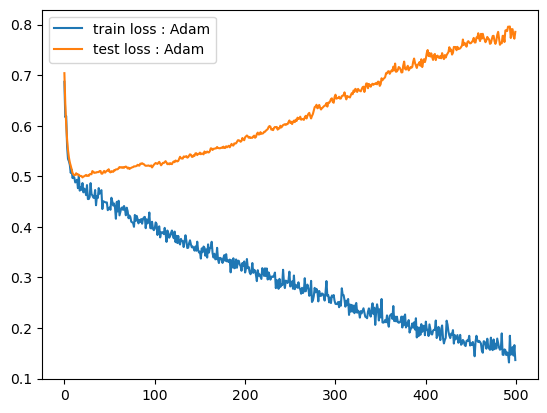

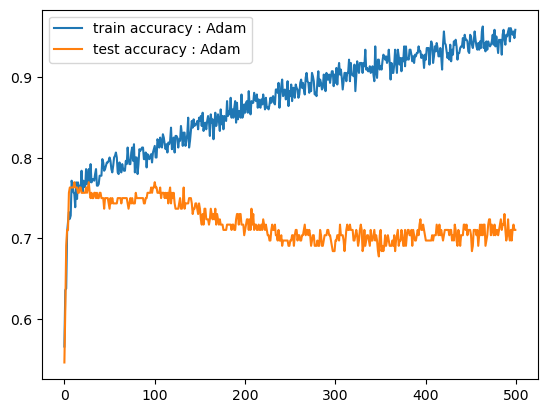

loss : 0.7857 and  accuracy : 0.7105


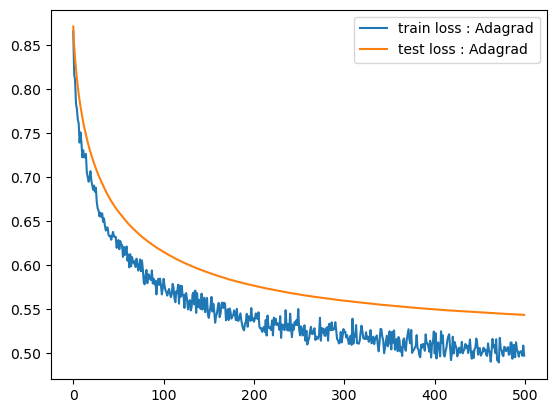

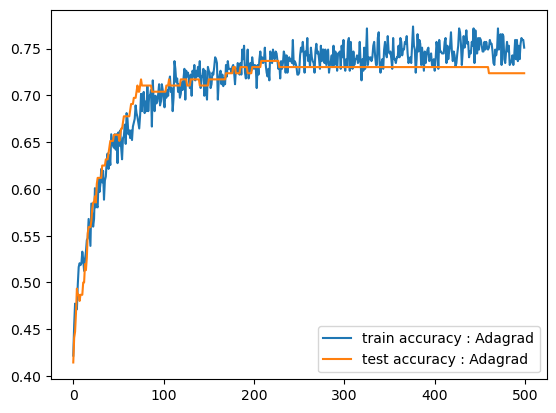

loss : 0.5431 and  accuracy : 0.7237


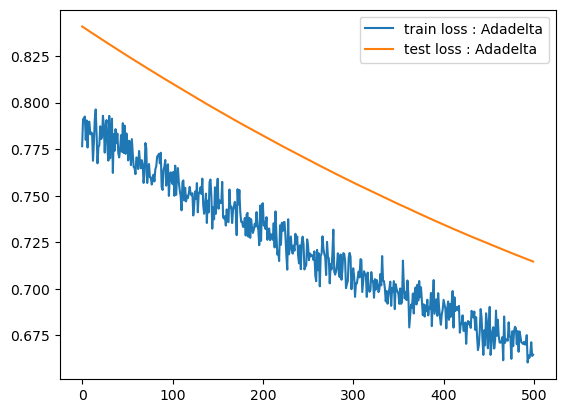

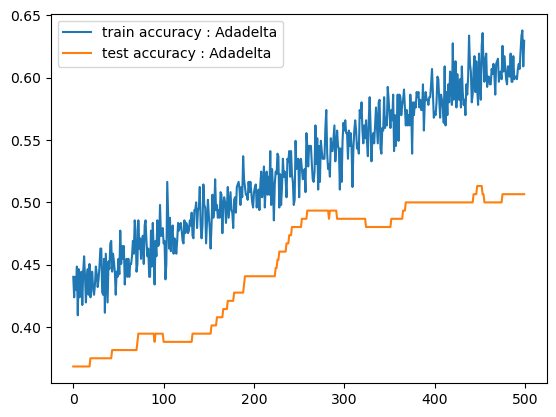

loss : 0.7147 and  accuracy : 0.5066


,optimizer,loss,accuracy
0,SGD,0.524574,0.756579
1,Adam,0.785722,0.710526
2,Adagrad,0.543129,0.723684
3,Adadelta,0.714658,0.506579


In [39]:
epochs = 500

model_config = {}
model_config['input_size'] = 7
model_config['layers'] = []
createModelConfigWithReLu(model_config, 0)
model = NeuralNetwork(model_config)

df_optimizer = []

optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=0.05)
runner,train_stats,test_stats = run(model, optimizer ,epochs,train_dataBatches,val_dataBatches)

plot_train_test(epochs, train_stats.loss, test_stats.loss, 'loss : ' + str('SGD'))
plot_train_test(epochs, train_stats.accuracy, test_stats.accuracy, 'accuracy : ' + str('SGD'))

runner = runner.eval(test_dataBatches)
loss, accuracy,_,_ = runner.get_eval_stats()

print(f'loss : {loss:.4f} and  accuracy : {accuracy:.4f}')

df_optimizer.append({
        "optimizer" : "SGD",
        "loss" : loss,
        "accuracy" : accuracy
})
if max_accuracy < accuracy:
        max_accuracy = accuracy
        max_acc_model = model
        max_model_config = model_config

model = NeuralNetwork(model_config)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
runner,train_stats,test_stats = run(model, optimizer ,epochs,train_dataBatches,val_dataBatches)

plot_train_test(epochs, train_stats.loss, test_stats.loss, 'loss : ' + str('Adam'))
plot_train_test(epochs, train_stats.accuracy, test_stats.accuracy, 'accuracy : ' + str('Adam'))

runner = runner.eval(test_dataBatches)
loss, accuracy,_,_ = runner.get_eval_stats()
print(f'loss : {loss:.4f} and  accuracy : {accuracy:.4f}')

df_optimizer.append({
        "optimizer" : "Adam",
        "loss" : loss,
        "accuracy" : accuracy
})

if max_accuracy < accuracy: 
        max_accuracy = accuracy
        max_acc_model = model
        max_model_config = model_config

model = NeuralNetwork(model_config)
optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)
runner,train_stats,test_stats = run(model, optimizer ,epochs,train_dataBatches,val_dataBatches)

plot_train_test(epochs, train_stats.loss, test_stats.loss, 'loss : ' + str('Adagrad'))
plot_train_test(epochs, train_stats.accuracy, test_stats.accuracy, 'accuracy : ' + str('Adagrad'))

runner = runner.eval(test_dataBatches)
loss, accuracy,_,_ = runner.get_eval_stats()

print(f'loss : {loss:.4f} and  accuracy : {accuracy:.4f}')

df_optimizer.append({
        "optimizer" : "Adagrad",
        "loss" : loss,
        "accuracy" : accuracy
})

if max_accuracy < accuracy:
        max_accuracy = accuracy
        max_acc_model = model
        max_model_config = model_config

model = NeuralNetwork(model_config)
optimizer = torch.optim.Adadelta(model.parameters(), lr = learning_rate)
runner,train_stats,test_stats = run(model, optimizer ,epochs,train_dataBatches,val_dataBatches)

plot_train_test(epochs, train_stats.loss, test_stats.loss, 'loss : ' + str('Adadelta'))
plot_train_test(epochs, train_stats.accuracy, test_stats.accuracy, 'accuracy : ' + str('Adadelta'))

runner = runner.eval(test_dataBatches)
loss, accuracy,_,_ = runner.get_eval_stats()

print(f'loss : {loss:.4f} and  accuracy : {accuracy:.4f}')

df_optimizer.append({
        "optimizer" : "Adadelta",
        "loss" : loss,
        "accuracy" : accuracy
})

if max_accuracy < accuracy:
        max_accuracy = accuracy
        max_acc_model = model
        max_model_config = model_config

df_optimizer = pd.DataFrame.from_records(df_optimizer)
df_optimizer

In [40]:

def createModelConfig(model_config,activation_fn, dropout = 0.0):
    model_config['layers'].extend([
            {
                "type" : "Linear",
                "input_size" : 7,
                "output_size" : 64
            },
            {
                "type" : activation_fn
            },
            {
                "type" : "Linear",
                "input_size" : 64,
                "output_size" : 64
            },
            {
                "type" : "Norm",
                "size" : 64
            },
            {
                "type" : "Linear",
                "input_size" : 64,
                "output_size" : 64
            },
            {
                "type" : activation_fn
            },
            {
                "type" : "Linear",
                "input_size" : 64,
                "output_size" : 1
            }
        ])


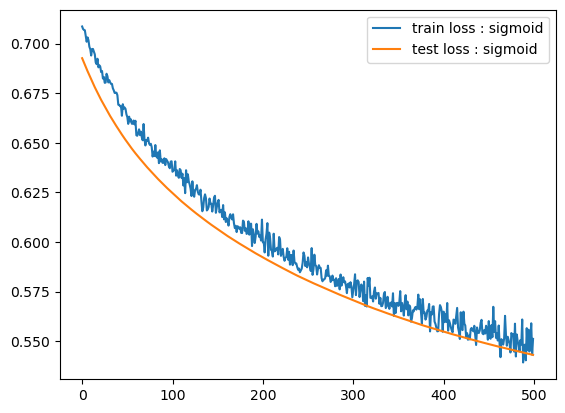

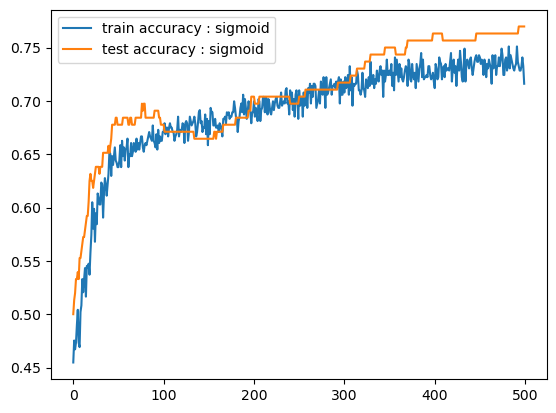

loss : 0.5431 and  accuracy : 0.7697


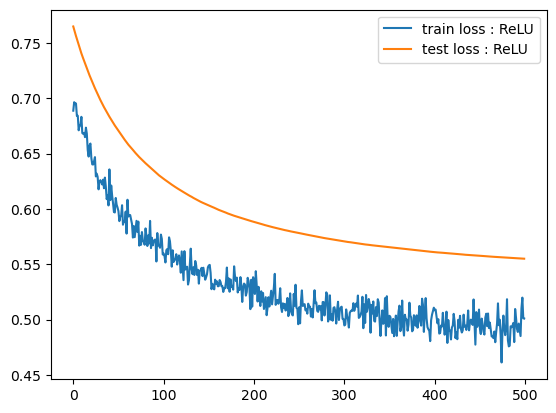

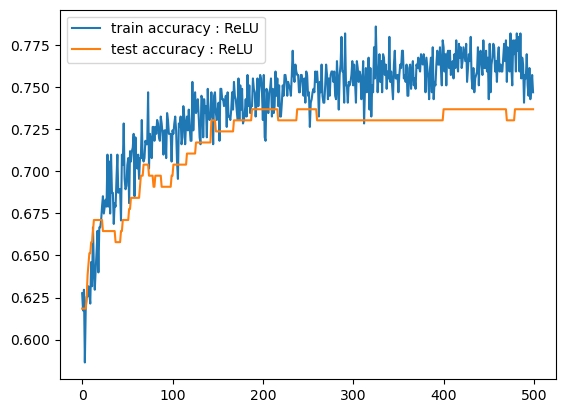

loss : 0.5550 and  accuracy : 0.7368


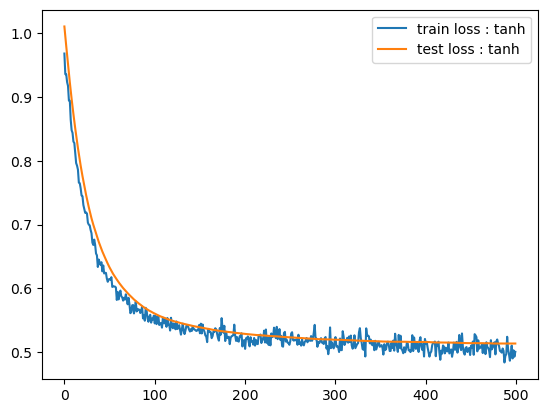

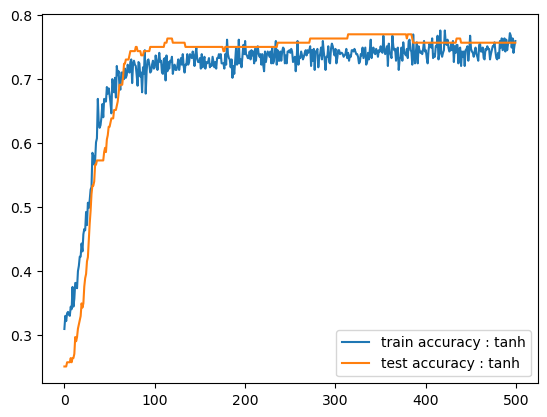

loss : 0.5132 and  accuracy : 0.7566


,activation_fn,loss,accuracy
0,sigmoid,0.543070,0.769737
1,ReLU,0.555035,0.736842
2,tanh,0.513197,0.756579


In [41]:
epochs = 500

model_config = {}
model_config['input_size'] = 7
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=0.05)

df_activation_fn = []
model_config['layers'] = []
createModelConfig(model_config, "sigmoid", 0.0)


model = NeuralNetwork(model_config)
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
runner,train_stats,test_stats = run(model, optimizer ,epochs,train_dataBatches,val_dataBatches)

plot_train_test(epochs, train_stats.loss, test_stats.loss, 'loss : ' + str('sigmoid'))
plot_train_test(epochs, train_stats.accuracy, test_stats.accuracy, 'accuracy : ' + str('sigmoid'))

runner = runner.eval(test_dataBatches)

loss, accuracy,_,_ = runner.get_eval_stats()

print(f'loss : {loss:.4f} and  accuracy : {accuracy:.4f}')

df_activation_fn.append({
        "activation_fn" : "sigmoid",
        "loss" : loss,
        "accuracy" : accuracy
})

if max_accuracy < accuracy:
        max_accuracy = accuracy
        max_acc_model = model
        max_model_config = model_config

model_config['layers'] = []
createModelConfig(model_config, "ReLU", 0.0)

model = NeuralNetwork(model_config)
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
runner,train_stats,test_stats = run(model, optimizer ,epochs,train_dataBatches,val_dataBatches)

plot_train_test(epochs, train_stats.loss, test_stats.loss, 'loss : ' + str('ReLU'))
plot_train_test(epochs, train_stats.accuracy, test_stats.accuracy, 'accuracy : ' + str('ReLU'))


runner = runner.eval(test_dataBatches)
loss, accuracy,_,_ = runner.get_eval_stats()

print(f'loss : {loss:.4f} and  accuracy : {accuracy:.4f}')

df_activation_fn.append({
        "activation_fn" : "ReLU",
        "loss" : loss,
        "accuracy" : accuracy
})
if max_accuracy < accuracy:
        max_accuracy = accuracy
        max_acc_model = model
        max_model_config = model_config


model_config['layers'] = []
createModelConfig(model_config, "tanh", 0.0)
model = NeuralNetwork(model_config)
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

runner,train_stats,test_stats = run(model, optimizer ,epochs,train_dataBatches,val_dataBatches)

plot_train_test(epochs, train_stats.loss, test_stats.loss, 'loss : ' + str('tanh'))
plot_train_test(epochs, train_stats.accuracy, test_stats.accuracy, 'accuracy : ' + str('tanh'))


runner = runner.eval(test_dataBatches)
loss, accuracy,_,_ = runner.get_eval_stats()

print(f'loss : {loss:.4f} and  accuracy : {accuracy:.4f}')

df_activation_fn.append({
        "activation_fn" : "tanh",
        "loss" : loss,
        "accuracy" : accuracy
})
if max_accuracy < accuracy:
        max_accuracy = accuracy
        max_acc_model = model
        max_model_config = model_config
        
df_activation_fn = pd.DataFrame.from_records(df_activation_fn)
df_activation_fn


In [42]:
print(max_accuracy)

0.7697368421052632


In [55]:
torch.save(max_acc_model.state_dict(), 'hpoola_assignment2_checkpoint_2.pth')

In [62]:

weigths = torch.load('hpoola_assignment2_checkpoint_2.pth')


In [63]:
max_accuracy

0.7697368421052632

## **Note :** Please test my model using the following cell to create a model and load the weights

In [64]:
model_config = {}
model_config['input_size'] = 7
model_config['layers'] = []

def createModelConfigWithReLu(model_config, dropout = 0.0):
    model_config['layers'].extend([
            {
                "type" : "Linear",
                "input_size" : 7,
                "output_size" : 64
            },
            {
                "type" : "LReLU"
            },
            {
                "type": "Dropout",
                "p" : dropout 
            },
            {
                "type" : "Linear",
                "input_size" : 64,
                "output_size" : 64
            },
            {
                "type" : "Norm",
                "size" : 64
            },
            {
                "type": "Dropout",
                "p" : dropout 
            },
            {
                "type" : "Linear",
                "input_size" : 64,
                "output_size" : 64
            },
            {
                "type" : "LReLU"
            },
            {
                "type": "Dropout",
                "p" : dropout
            },
            {
                "type" : "Linear",
                "input_size" : 64,
                "output_size" : 1
            }
        ])

In [65]:
createModelConfigWithReLu(model_config,0.0)
model_test = NeuralNetwork(model_config)
model_test.load_state_dict(weigths)

runner = ModelRunner(model_test,device,loss_function, batch_size).eval(test_dataBatches)
loss, accuracy,_,_ = runner.get_eval_stats()
print(loss, accuracy)

0.5114344879984856 0.7960526315789473


## Experiment 3 
### Early stopping on 'base' model

In [47]:
# model_test
model_3 = NeuralNetwork(max_model_config)
optimizer = torch.optim.SGD(model_3.parameters(),lr=learning_rate)
model_3

NeuralNetwork(
  (layers): Sequential(
    (0): Linear(in_features=7, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): Tanh()
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [48]:
class EarlyStopping:
    def __init__(self, validation_fn, patience=3):
        self.patience = patience
        self.validation_fn = validation_fn
        self.temp_patience = 0 # 1, 2, 3

    def check(self, train_loss, val_loss):
        if (self.validation_fn(train_loss,val_loss,0.005)):
            self.temp_patience = self.temp_patience + 1
            if self.temp_patience >= self.patience:  
                return True
        else:
            self.temp_patience = 0
        
        return False


In [49]:
validation_fn = lambda train_loss, val_loss, threshold : abs(val_loss - train_loss) < threshold

early_stopping = EarlyStopping(validation_fn)
runner = ModelRunner(model_3, device,loss_fn=loss_function, batch_size=batch_size)
train_loss_list = []
val_loss_list = []
earlystop_epochs = epochs

for i in range(1,epochs+1):
    
    runner = runner.train(train_dataBatches, optimizer)
    train_loss = runner.get_train_loss()
    train_loss_list.append(train_loss)

    runner = runner.eval(val_dataBatches)
    val_loss, val_acc,_,_ = runner.get_eval_stats()

    val_loss_list.append(val_loss)

    if early_stopping.check(train_loss, val_loss):
      earlystop_epochs = i
      break

earlystop_epochs = min(epochs, earlystop_epochs)
print(earlystop_epochs)
runner = runner.eval(test_dataBatches)
test_loss,test_acc,_,_ = runner.get_eval_stats()
print(test_loss, test_acc)

232
0.5425645150244236 0.75


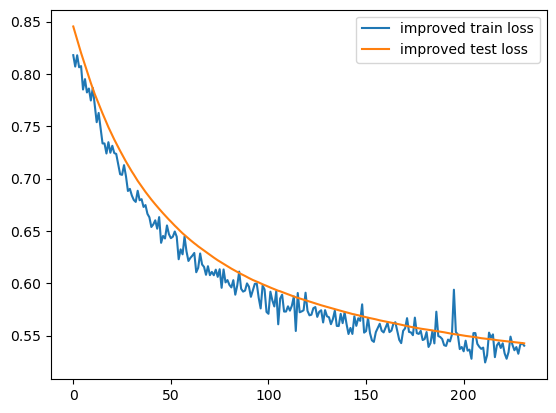

In [50]:
x_e_data = np.arange(0,earlystop_epochs,1)
plt.plot(x_e_data, train_loss_list, label='improved train loss')
plt.plot(x_e_data, val_loss_list, label='improved test loss')
plt.legend()
plt.show()

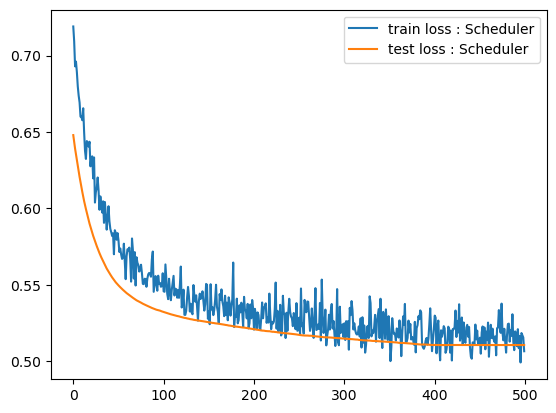

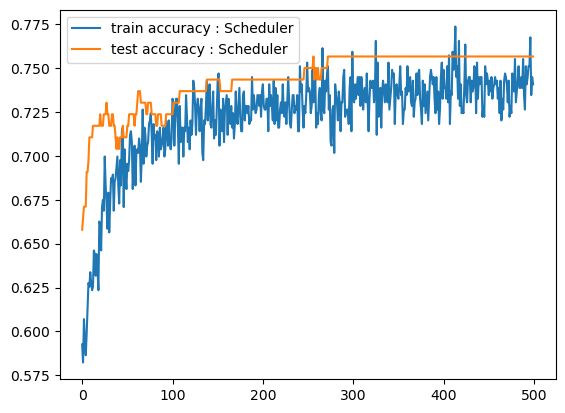

In [51]:
scheduler_model = NeuralNetwork(max_model_config)
scheduler_optimizer = torch.optim.SGD(scheduler_model.parameters(), lr = learning_rate)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(scheduler_optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001, threshold_mode='rel',
cooldown=0, min_lr=0, eps=1e-08)
runner,train_stats,test_stats = run(scheduler_model, scheduler_optimizer ,epochs,train_dataBatches,val_dataBatches,scheduler = scheduler)

plot_train_test(epochs, train_stats.loss, test_stats.loss, 'loss : ' + str('Scheduler'))
plot_train_test(epochs, train_stats.accuracy, test_stats.accuracy, 'accuracy : ' + str('Scheduler'))
